In [ ]:
pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
# first repo https://github.com/facebookresearch/detectron2

In [ ]:
import csv
from pydriller import Repository
from difflib import unified_diff, ndiff

# Function to clean lines: remove blank lines & ignore whitespace differences
def clean_lines(text):
    return [line.strip() for line in text.splitlines() if line.strip()]

# Function to compute diffs
def compute_diff(old_source, new_source, method="myers"):
    old_clean = clean_lines(old_source if old_source else "")
    new_clean = clean_lines(new_source if new_source else "")

    if method == "myers":
        diff = unified_diff(old_clean, new_clean, lineterm="", n=0)
        return "\n".join(diff)
    elif method == "histogram":
        diff = ndiff(old_clean, new_clean)
        # convert ndiff markers to unified-like markers for easier comparison
        converted_diff = []
        for line in diff:
            if line.startswith("+ "):
                converted_diff.append('+' + line[2:])
            elif line.startswith("- "):
                converted_diff.append('-' + line[2:])
            elif line.startswith("  "):
                converted_diff.append(' ' + line[2:])
        return "\n".join(converted_diff)
    else:
        raise ValueError(f"Unknown diff method: {method}")

# Function to extract only added/removed lines for meaningful discrepancy
def extract_changes(diff_text):
    changes = set()
    for line in diff_text.splitlines():
        if line.startswith("+") or line.startswith("-"):
            changes.add(line[1:].strip())  # remove marker and strip whitespace
    return changes

# Main extraction
def extract_repo_data(repo_path, output_csv):
    with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "old_file_path", "new_file_path",
            "commit_SHA", "parent_commit_SHA",
            "commit_message", "diff_myers", "diff_histogram", "Discrepancy"
        ])

        for commit in Repository(repo_path).traverse_commits():
            try:
                for mod in commit.modified_files:
                    old_file = mod.old_path if mod.old_path else "N/A"
                    new_file = mod.new_path if mod.new_path else "N/A"

                    diff_myers = compute_diff(mod.source_code_before, mod.source_code, method="myers")
                    diff_hist = compute_diff(mod.source_code_before, mod.source_code, method="histogram")

                    # Extract changes for meaningful discrepancy
                    changes_myers = extract_changes(diff_myers)
                    changes_hist = extract_changes(diff_hist)
                    discrepancy = "Yes" if changes_myers != changes_hist else "No"

                    parent_sha = ",".join(commit.parents) if commit.parents else "N/A"

                    writer.writerow([
                        old_file, new_file,
                        commit.hash, parent_sha,
                        commit.msg.strip(),
                        diff_myers, diff_hist, discrepancy
                    ])
            except Exception as e:
                print(f"⚠️ Skipping commit {getattr(commit, 'hash', 'UNKNOWN')}: {e}")

if __name__ == "__main__":
    # Example usage: pass your repo path and desired output file
    repo = "https://github.com/facebookresearch/detectron2"  # replace with your repo directory
    out_csv = "o1i.csv"
    extract_repo_data(repo, out_csv)
    print(f"Dataset saved to {out_csv}")

Dataset saved to o1i.csv


In [ ]:
import csv
import sys

# Increase the CSV field size limit to handle large diffs
csv.field_size_limit(sys.maxsize)

file_path = "/content/o1i.csv"
found_no = False

with open(file_path, newline="", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    i=0
    for row_num, row in enumerate(reader, start=2):  # start=2 to account for header row
        if row["Discrepancy"].strip().lower() == "no":
            found_no = True
            i=i+1
            print(f"Row {i,row_num} with 'No' found: Commit {row['commit_SHA']}, File {row['new_file_path']}")
            # Uncomment below if you only want to know the first occurrence
            # break

if not found_no:
    print("No rows with 'Discrepancy = No' found in the file.")

Row (1, 380) with 'No' found: Commit 817050985edb0a6a5ee6b795a6653dceed36d933, File setup.py
Row (2, 389) with 'No' found: Commit e67f8812380fe2225ff53f66b7a381e0ab1ca2b4, File GETTING_STARTED.md
Row (3, 443) with 'No' found: Commit d01c8617dc88dcc2157f456870c95d6be40f3f3d, File detectron2/data/build.py
Row (4, 444) with 'No' found: Commit d01c8617dc88dcc2157f456870c95d6be40f3f3d, File detectron2/data/catalog.py
Row (5, 452) with 'No' found: Commit d01c8617dc88dcc2157f456870c95d6be40f3f3d, File detectron2/layers/mask_ops.py
Row (6, 453) with 'No' found: Commit d01c8617dc88dcc2157f456870c95d6be40f3f3d, File detectron2/layers/nms.py
Row (7, 501) with 'No' found: Commit 6513a475656778c84bdd2b416b03e5bcdda6c841, File .github/CODE_OF_CONDUCT.md
Row (8, 502) with 'No' found: Commit 6513a475656778c84bdd2b416b03e5bcdda6c841, File .github/CONTRIBUTING.md
Row (9, 512) with 'No' found: Commit 4fe0d8f10a13016c2a802e5e47af67ebe5576fc3, File detectron2/utils/visualizer.py
Row (10, 665) with 'No' fou

Mismatch counts by file type:
File_Type
Source Code    4083
Test Code       661
README          167
LICENSE           3
Name: count, dtype: int64


/tmp/ipython-input-2010302514.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches["File_Type"] = mismatches["new_file_path"].apply(classify_file)


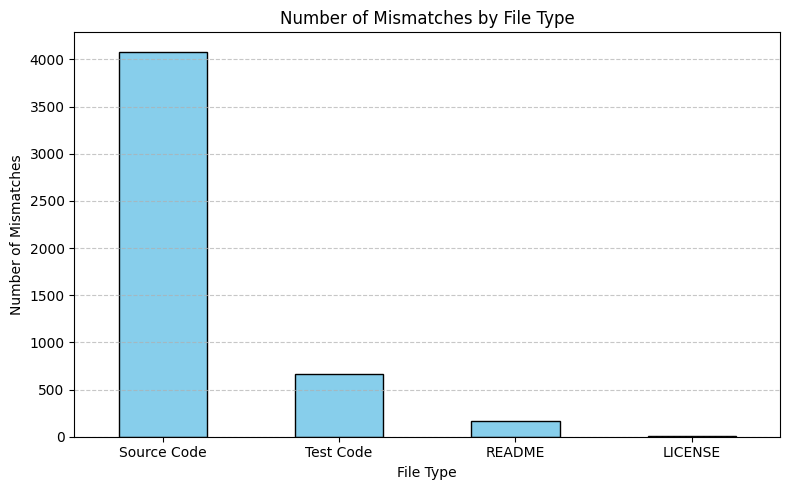

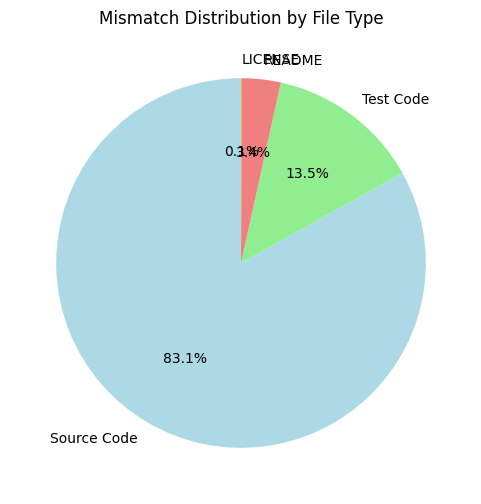

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("/content/o1i.csv")  # replace with your CSV file

# Filter only mismatches (case-insensitive)
mismatches = df[df["Discrepancy"].str.strip().str.lower() == "yes"]

# Function to classify file type into exactly 4 required categories
def classify_file(path):
    if pd.isna(path) or path == "N/A":
        return None
    path = path.lower()
    if "test" in path:
        return "Test Code"
    elif "readme" in path:
        return "README"
    elif "license" in path:
        return "LICENSE"
    elif path.endswith(('.py', '.java', '.cpp', '.c', '.js', '.ts', '.rb', '.go', '.rs', '.h', '.cu')):
        return "Source Code"
    else:
        return None  # ignore other file types

# Apply classification to new_file_path
mismatches["File_Type"] = mismatches["new_file_path"].apply(classify_file)

# Keep only rows that fall into the 4 categories
mismatches = mismatches[mismatches["File_Type"].notna()]

# Count mismatches per category
stats = mismatches["File_Type"].value_counts()

print("Mismatch counts by file type:")
print(stats)

# --- Bar Chart ---
plt.figure(figsize=(8,5))
stats.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Mismatches by File Type")
plt.xlabel("File Type")
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- Pie Chart ---
plt.figure(figsize=(6,6))
stats.plot(kind="pie", autopct="%1.1f%%", startangle=90,
           colors=["lightblue", "lightgreen", "lightcoral", "orange"])
plt.title("Mismatch Distribution by File Type")
plt.ylabel("")  # remove y-label
plt.show()

In [ ]:
# second repo https://github.com/unclecode/crawl4ai

In [ ]:
import csv
from pydriller import Repository
from difflib import unified_diff, ndiff

# Function to clean lines: remove blank lines & ignore whitespace differences
def clean_lines(text):
    return [line.strip() for line in text.splitlines() if line.strip()]

# Function to compute diffs
def compute_diff(old_source, new_source, method="myers"):
    old_clean = clean_lines(old_source if old_source else "")
    new_clean = clean_lines(new_source if new_source else "")

    if method == "myers":
        diff = unified_diff(old_clean, new_clean, lineterm="", n=0)
        return "\n".join(diff)
    elif method == "histogram":
        diff = ndiff(old_clean, new_clean)
        # convert ndiff markers to unified-like markers for easier comparison
        converted_diff = []
        for line in diff:
            if line.startswith("+ "):
                converted_diff.append('+' + line[2:])
            elif line.startswith("- "):
                converted_diff.append('-' + line[2:])
            elif line.startswith("  "):
                converted_diff.append(' ' + line[2:])
        return "\n".join(converted_diff)
    else:
        raise ValueError(f"Unknown diff method: {method}")

# Function to extract only added/removed lines for meaningful discrepancy
def extract_changes(diff_text):
    changes = set()
    for line in diff_text.splitlines():
        if line.startswith("+") or line.startswith("-"):
            changes.add(line[1:].strip())  # remove marker and strip whitespace
    return changes

# Main extraction
def extract_repo_data(repo_path, output_csv):
    with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "old_file_path", "new_file_path",
            "commit_SHA", "parent_commit_SHA",
            "commit_message", "diff_myers", "diff_histogram", "Discrepancy"
        ])

        for commit in Repository(repo_path).traverse_commits():
            try:
                for mod in commit.modified_files:
                    old_file = mod.old_path if mod.old_path else "N/A"
                    new_file = mod.new_path if mod.new_path else "N/A"

                    diff_myers = compute_diff(mod.source_code_before, mod.source_code, method="myers")
                    diff_hist = compute_diff(mod.source_code_before, mod.source_code, method="histogram")

                    # Extract changes for meaningful discrepancy
                    changes_myers = extract_changes(diff_myers)
                    changes_hist = extract_changes(diff_hist)
                    discrepancy = "Yes" if changes_myers != changes_hist else "No"

                    parent_sha = ",".join(commit.parents) if commit.parents else "N/A"

                    writer.writerow([
                        old_file, new_file,
                        commit.hash, parent_sha,
                        commit.msg.strip(),
                        diff_myers, diff_hist, discrepancy
                    ])
            except Exception as e:
                print(f"⚠️ Skipping commit {getattr(commit, 'hash', 'UNKNOWN')}: {e}")

if __name__ == "__main__":
    # Example usage: pass your repo path and desired output file
    repo = "https://github.com/unclecode/crawl4ai"  # replace with your repo directory
    out_csv = "o2i.csv"
    extract_repo_data(repo, out_csv)
    print(f"Dataset saved to {out_csv}")

Dataset saved to o2i.csv


In [ ]:
import csv
import sys

# Increase the CSV field size limit to handle large diffs
csv.field_size_limit(sys.maxsize)

file_path = "/content/o2i.csv"
found_no = False

with open(file_path, newline="", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row_num, row in enumerate(reader, start=2):  # start=2 to account for header row
        if row["Discrepancy"].strip().lower() == "no":
            found_no = True
            print(f"Row {row_num} with 'No' found: Commit {row['commit_SHA']}, File {row['new_file_path']}")
            # Uncomment below if you only want to know the first occurrence
            # break

if not found_no:
    print("No rows with 'Discrepancy = No' found in the file.")

Row 28 with 'No' found: Commit 51095062d47b16ef2ae3eb54b8a97d151d8b5c75, File examples/quickstart.py
Row 37 with 'No' found: Commit 3ff1d1570238fd7bce976165111a69bbabc62e4a, File crawl4ai/__init__.py
Row 38 with 'No' found: Commit 3ff1d1570238fd7bce976165111a69bbabc62e4a, File crawl4ai/config.py
Row 39 with 'No' found: Commit 3ff1d1570238fd7bce976165111a69bbabc62e4a, File crawl4ai/database.py
Row 40 with 'No' found: Commit 3ff1d1570238fd7bce976165111a69bbabc62e4a, File crawl4ai/models.py
Row 41 with 'No' found: Commit 3ff1d1570238fd7bce976165111a69bbabc62e4a, File crawl4ai/prompts.py
Row 42 with 'No' found: Commit 3ff1d1570238fd7bce976165111a69bbabc62e4a, File crawl4ai/utils.py
Row 43 with 'No' found: Commit 3ff1d1570238fd7bce976165111a69bbabc62e4a, File crawl4ai/web_crawler.py
Row 81 with 'No' found: Commit 82706129f5ee14dc1804778f4828c94ec1bb69ba, File models/reuters/vocab/key2row
Row 82 with 'No' found: Commit 82706129f5ee14dc1804778f4828c94ec1bb69ba, File models/reuters/vocab/looku

/tmp/ipython-input-2622975935.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches["File_Type"] = mismatches["new_file_path"].apply(classify_file)


Mismatch counts by file type:
File_Type
Source Code    1655
Test Code       232
README          227
LICENSE           2
Name: count, dtype: int64


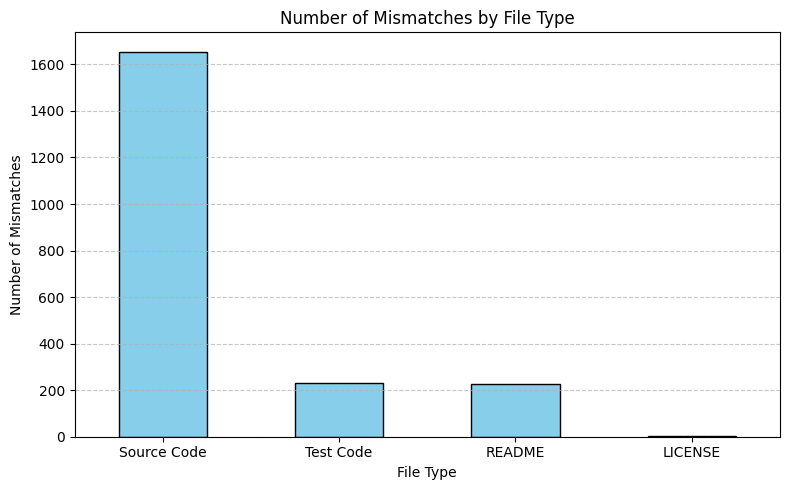

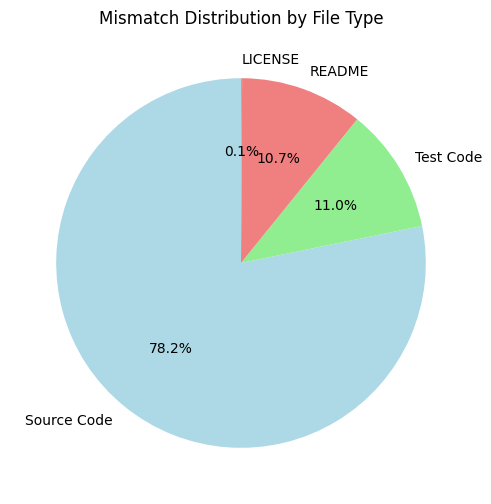

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("/content/o2i.csv")  # replace with your CSV file

# Filter only mismatches (case-insensitive)
mismatches = df[df["Discrepancy"].str.strip().str.lower() == "yes"]

# Function to classify file type into exactly 4 required categories
def classify_file(path):
    if pd.isna(path) or path == "N/A":
        return None
    path = path.lower()
    if "test" in path:
        return "Test Code"
    elif "readme" in path:
        return "README"
    elif "license" in path:
        return "LICENSE"
    elif path.endswith(('.py', '.java', '.cpp', '.c', '.js', '.ts', '.rb', '.go', '.rs', '.h', '.cu')):
        return "Source Code"
    else:
        return None  # ignore other file types

# Apply classification to new_file_path
mismatches["File_Type"] = mismatches["new_file_path"].apply(classify_file)

# Keep only rows that fall into the 4 categories
mismatches = mismatches[mismatches["File_Type"].notna()]

# Count mismatches per category
stats = mismatches["File_Type"].value_counts()

print("Mismatch counts by file type:")
print(stats)

# --- Bar Chart ---
plt.figure(figsize=(8,5))
stats.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Mismatches by File Type")
plt.xlabel("File Type")
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- Pie Chart ---
plt.figure(figsize=(6,6))
stats.plot(kind="pie", autopct="%1.1f%%", startangle=90,
           colors=["lightblue", "lightgreen", "lightcoral", "orange"])
plt.title("Mismatch Distribution by File Type")
plt.ylabel("")  # remove y-label
plt.show()

In [ ]:
# third repo https://github.com/deepspeedai/DeepSpeed

In [ ]:
import csv
from pydriller import Repository
from difflib import unified_diff, ndiff

# Function to clean lines: remove blank lines & ignore whitespace differences
def clean_lines(text):
    return [line.strip() for line in text.splitlines() if line.strip()]

# Function to compute diffs
def compute_diff(old_source, new_source, method="myers"):
    old_clean = clean_lines(old_source if old_source else "")
    new_clean = clean_lines(new_source if new_source else "")

    if method == "myers":
        diff = unified_diff(old_clean, new_clean, lineterm="", n=0)
        return "\n".join(diff)
    elif method == "histogram":
        diff = ndiff(old_clean, new_clean)
        # convert ndiff markers to unified-like markers for easier comparison
        converted_diff = []
        for line in diff:
            if line.startswith("+ "):
                converted_diff.append('+' + line[2:])
            elif line.startswith("- "):
                converted_diff.append('-' + line[2:])
            elif line.startswith("  "):
                converted_diff.append(' ' + line[2:])
        return "\n".join(converted_diff)
    else:
        raise ValueError(f"Unknown diff method: {method}")

# Function to extract only added/removed lines for meaningful discrepancy
def extract_changes(diff_text):
    changes = set()
    for line in diff_text.splitlines():
        if line.startswith("+") or line.startswith("-"):
            changes.add(line[1:].strip())  # remove marker and strip whitespace
    return changes

# Main extraction
def extract_repo_data(repo_path, output_csv):
    with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "old_file_path", "new_file_path",
            "commit_SHA", "parent_commit_SHA",
            "commit_message", "diff_myers", "diff_histogram", "Discrepancy"
        ])

        for commit in Repository(repo_path).traverse_commits():
            try:
                for mod in commit.modified_files:
                    old_file = mod.old_path if mod.old_path else "N/A"
                    new_file = mod.new_path if mod.new_path else "N/A"

                    diff_myers = compute_diff(mod.source_code_before, mod.source_code, method="myers")
                    diff_hist = compute_diff(mod.source_code_before, mod.source_code, method="histogram")

                    # Extract changes for meaningful discrepancy
                    changes_myers = extract_changes(diff_myers)
                    changes_hist = extract_changes(diff_hist)
                    discrepancy = "Yes" if changes_myers != changes_hist else "No"

                    parent_sha = ",".join(commit.parents) if commit.parents else "N/A"

                    writer.writerow([
                        old_file, new_file,
                        commit.hash, parent_sha,
                        commit.msg.strip(),
                        diff_myers, diff_hist, discrepancy
                    ])
            except Exception as e:
                print(f"⚠️ Skipping commit {getattr(commit, 'hash', 'UNKNOWN')}: {e}")

if __name__ == "__main__":
    # Example usage: pass your repo path and desired output file
    repo = "https://github.com/deepspeedai/DeepSpeed"  # replace with your repo directory
    out_csv = "o3i.csv"
    extract_repo_data(repo, out_csv)
    print(f"Dataset saved to {out_csv}")

⚠️ Skipping commit be79aaec178a9397b9c353c3ccf0511647e66f28: SHA b'880ab925bce9f817a93988b021e12db5f67f7787' could not be resolved, git returned: b'880ab925bce9f817a93988b021e12db5f67f7787 missing'
⚠️ Skipping commit 3bc21cd042f4b64f59b7aaf8bcfdf327d28f3589: SHA b'69785c7cff23b0d2f7e4d96bc6a0a442f9b60a94' could not be resolved, git returned: b'69785c7cff23b0d2f7e4d96bc6a0a442f9b60a94 missing'
⚠️ Skipping commit bb91a3ef4b3a7a5b5009b501720b80e8227594ef: SHA b'69785c7cff23b0d2f7e4d96bc6a0a442f9b60a94' could not be resolved, git returned: b'69785c7cff23b0d2f7e4d96bc6a0a442f9b60a94 missing'
⚠️ Skipping commit 9f2e54c09ebf126fc1082224831aa8a325c62ad2: SHA b'95a159903ab10b8b0e967acff04e5216db90df27' could not be resolved, git returned: b'95a159903ab10b8b0e967acff04e5216db90df27 missing'
⚠️ Skipping commit 81a708e7ba80c32ce8e95a126406138930684125: SHA b'a18f48a58c887dcab8806148718031f8451ce885' could not be resolved, git returned: b'a18f48a58c887dcab8806148718031f8451ce885 missing'
⚠️ Skippin

In [ ]:
import csv
import sys

# Increase the CSV field size limit to handle large diffs
csv.field_size_limit(sys.maxsize)

file_path = "/content/o3i.csv"
found_no = False

with open(file_path, newline="", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row_num, row in enumerate(reader, start=2):  # start=2 to account for header row
        if row["Discrepancy"].strip().lower() == "no":
            found_no = True
            print(f"Row {row_num} with 'No' found: Commit {row['commit_SHA']}, File {row['new_file_path']}")
            # Uncomment below if you only want to know the first occurrence
            # break

if not found_no:
    print("No rows with 'Discrepancy = No' found in the file.")

Row 33 with 'No' found: Commit c04ae78a8b50e009792a509070a36a2571e4c8ef, File csrc/tmp
Row 39 with 'No' found: Commit b18eae24e897f4844df33eb3688e206ff27cbf2b, File deepspeed/__init__.py
Row 40 with 'No' found: Commit b18eae24e897f4844df33eb3688e206ff27cbf2b, File deepspeed/pt/deepspeed_dataloader.py
Row 41 with 'No' found: Commit b18eae24e897f4844df33eb3688e206ff27cbf2b, File deepspeed/pt/deepspeed_launch.py
Row 42 with 'No' found: Commit b18eae24e897f4844df33eb3688e206ff27cbf2b, File deepspeed/pt/deepspeed_run.py
Row 43 with 'No' found: Commit b18eae24e897f4844df33eb3688e206ff27cbf2b, File install.sh
Row 46 with 'No' found: Commit a5acb5b22dc6ff148c477a6d926282c76d850f3c, File deepspeed/pt/deepspeed_csr_tensor.py
Row 67 with 'No' found: Commit 681001fb6d44f7907d80ceac3ccf07a7f3a6bd36, File deepspeed/pt/__init__.py
Row 68 with 'No' found: Commit 681001fb6d44f7907d80ceac3ccf07a7f3a6bd36, File deepspeed/pt/deepspeed_utils.py
Row 230 with 'No' found: Commit 936117b589e848318c44deb3ce1286

Mismatch counts by file type:
File_Type
Source Code    6250
Test Code      1935
README          410
LICENSE          10
Name: count, dtype: int64


/tmp/ipython-input-2848617215.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches["File_Type"] = mismatches["new_file_path"].apply(classify_file)


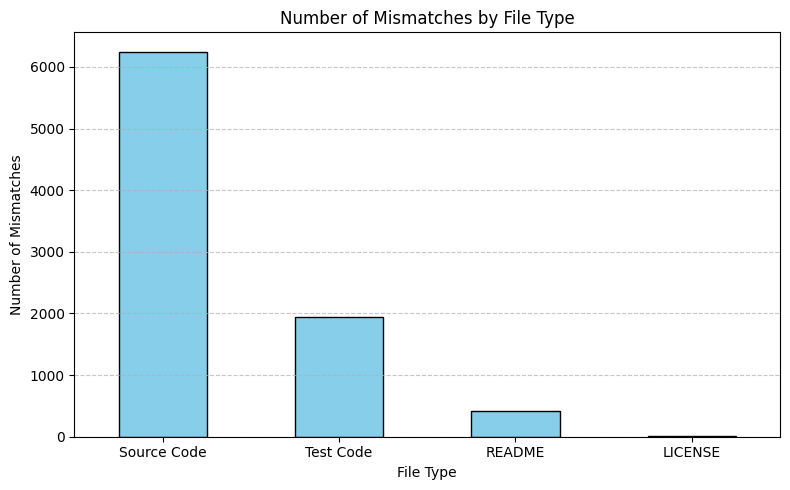

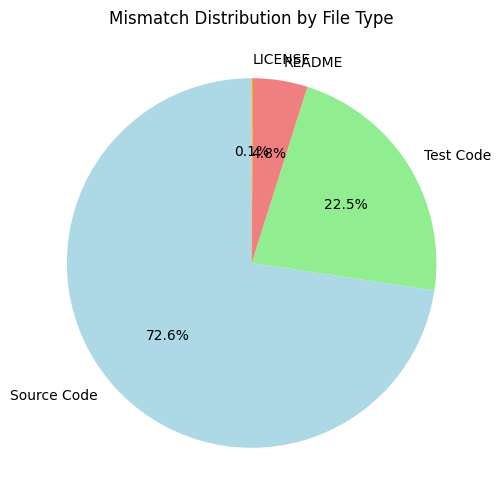

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("/content/o3i.csv")  # replace with your CSV file

# Filter only mismatches (case-insensitive)
mismatches = df[df["Discrepancy"].str.strip().str.lower() == "yes"]

# Function to classify file type into exactly 4 required categories
def classify_file(path):
    if pd.isna(path) or path == "N/A":
        return None
    path = path.lower()
    if "test" in path:
        return "Test Code"
    elif "readme" in path:
        return "README"
    elif "license" in path:
        return "LICENSE"
    elif path.endswith(('.py', '.java', '.cpp', '.c', '.js', '.ts', '.rb', '.go', '.rs', '.h', '.cu')):
        return "Source Code"
    else:
        return None  # ignore other file types

# Apply classification to new_file_path
mismatches["File_Type"] = mismatches["new_file_path"].apply(classify_file)

# Keep only rows that fall into the 4 categories
mismatches = mismatches[mismatches["File_Type"].notna()]

# Count mismatches per category
stats = mismatches["File_Type"].value_counts()

print("Mismatch counts by file type:")
print(stats)

# --- Bar Chart ---
plt.figure(figsize=(8,5))
stats.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Mismatches by File Type")
plt.xlabel("File Type")
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- Pie Chart ---
plt.figure(figsize=(6,6))
stats.plot(kind="pie", autopct="%1.1f%%", startangle=90,
           colors=["lightblue", "lightgreen", "lightcoral", "orange"])
plt.title("Mismatch Distribution by File Type")
plt.ylabel("")  # remove y-label
plt.show()

In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("o1i.csv")  # replace with your CSV

# Fill NaN diffs with empty strings instead of dropping rows
df['diff_myers'] = df['diff_myers'].fillna("")
df['diff_histogram'] = df['diff_histogram'].fillna("")

# Function to count changed lines in a diff
def count_changes(diff_text):
    if not diff_text:
        return 0
    return sum(1 for line in diff_text.splitlines() if line.startswith(("+", "-")))

# Compute line counts for each diff
df['myers_lines'] = df['diff_myers'].apply(count_changes)
df['hist_lines'] = df['diff_histogram'].apply(count_changes)

# Count total discrepancies
num_discrepancies = df[df['Discrepancy'].str.strip().str.lower() == "yes"].shape[0]

# Total commits (all rows in CSV)
total_commits = df.shape[0]

# Agreement rate
agreement_rate = (total_commits - num_discrepancies) / total_commits * 100

# Compare average diff sizes
avg_myers = df['myers_lines'].mean()
avg_hist = df['hist_lines'].mean()

# Decide which algorithm is "better" automatically
if avg_myers < avg_hist:
    better_algorithm = "Myers (more concise diffs)"
elif avg_hist < avg_myers:
    better_algorithm = "Histogram (more concise diffs)"
else:
    better_algorithm = "Both algorithms are equally concise"

# Print results
print(f"Total commits analyzed: {total_commits}")
print(f"Number of discrepancies (Yes): {num_discrepancies}")
print(f"Number of agreements (No): {total_commits - num_discrepancies}")
print(f"Agreement rate between Myers and Histogram: {agreement_rate:.2f}%")
print(f"Average changed lines per commit (Myers): {avg_myers:.2f}")
print(f"Average changed lines per commit (Histogram): {avg_hist:.2f}")
print(f"Automatically determined better algorithm: {better_algorithm}")

Total commits analyzed: 6186
Number of discrepancies (Yes): 6086
Number of agreements (No): 100
Agreement rate between Myers and Histogram: 1.62%
Average changed lines per commit (Myers): 23.87
Average changed lines per commit (Histogram): 21.79
Automatically determined better algorithm: Histogram (more concise diffs)


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("o2i.csv")  # replace with your CSV

# Fill NaN diffs with empty strings instead of dropping rows
df['diff_myers'] = df['diff_myers'].fillna("")
df['diff_histogram'] = df['diff_histogram'].fillna("")

# Function to count changed lines in a diff
def count_changes(diff_text):
    if not diff_text:
        return 0
    return sum(1 for line in diff_text.splitlines() if line.startswith(("+", "-")))

# Compute line counts for each diff
df['myers_lines'] = df['diff_myers'].apply(count_changes)
df['hist_lines'] = df['diff_histogram'].apply(count_changes)

# Count total discrepancies
num_discrepancies = df[df['Discrepancy'].str.strip().str.lower() == "yes"].shape[0]

# Total commits (all rows in CSV)
total_commits = df.shape[0]

# Agreement rate
agreement_rate = (total_commits - num_discrepancies) / total_commits * 100

# Compare average diff sizes
avg_myers = df['myers_lines'].mean()
avg_hist = df['hist_lines'].mean()

# Decide which algorithm is "better" automatically
if avg_myers < avg_hist:
    better_algorithm = "Myers (more concise diffs)"
elif avg_hist < avg_myers:
    better_algorithm = "Histogram (more concise diffs)"
else:
    better_algorithm = "Both algorithms are equally concise"

# Print results
print(f"Total commits analyzed: {total_commits}")
print(f"Number of discrepancies (Yes): {num_discrepancies}")
print(f"Number of agreements (No): {total_commits - num_discrepancies}")
print(f"Agreement rate between Myers and Histogram: {agreement_rate:.2f}%")
print(f"Average changed lines per commit (Myers): {avg_myers:.2f}")
print(f"Average changed lines per commit (Histogram): {avg_hist:.2f}")
print(f"Automatically determined better algorithm: {better_algorithm}")

Total commits analyzed: 4199
Number of discrepancies (Yes): 3979
Number of agreements (No): 220
Agreement rate between Myers and Histogram: 5.24%
Average changed lines per commit (Myers): 208.29
Average changed lines per commit (Histogram): 206.07
Automatically determined better algorithm: Histogram (more concise diffs)


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("o3i.csv")  # replace with your CSV

# Fill NaN diffs with empty strings instead of dropping rows
df['diff_myers'] = df['diff_myers'].fillna("")
df['diff_histogram'] = df['diff_histogram'].fillna("")

# Function to count changed lines in a diff
def count_changes(diff_text):
    if not diff_text:
        return 0
    return sum(1 for line in diff_text.splitlines() if line.startswith(("+", "-")))

# Compute line counts for each diff
df['myers_lines'] = df['diff_myers'].apply(count_changes)
df['hist_lines'] = df['diff_histogram'].apply(count_changes)

# Count total discrepancies
num_discrepancies = df[df['Discrepancy'].str.strip().str.lower() == "yes"].shape[0]

# Total commits (all rows in CSV)
total_commits = df.shape[0]

# Agreement rate
agreement_rate = (total_commits - num_discrepancies) / total_commits * 100

# Compare average diff sizes
avg_myers = df['myers_lines'].mean()
avg_hist = df['hist_lines'].mean()

# Decide which algorithm is "better" automatically
if avg_myers < avg_hist:
    better_algorithm = "Myers (more concise diffs)"
elif avg_hist < avg_myers:
    better_algorithm = "Histogram (more concise diffs)"
else:
    better_algorithm = "Both algorithms are equally concise"

# Print results
print(f"Total commits analyzed: {total_commits}")
print(f"Number of discrepancies (Yes): {num_discrepancies}")
print(f"Number of agreements (No): {total_commits - num_discrepancies}")
print(f"Agreement rate between Myers and Histogram: {agreement_rate:.2f}%")
print(f"Average changed lines per commit (Myers): {avg_myers:.2f}")
print(f"Average changed lines per commit (Histogram): {avg_hist:.2f}")
print(f"Automatically determined better algorithm: {better_algorithm}")

Total commits analyzed: 11510
Number of discrepancies (Yes): 11221
Number of agreements (No): 289
Agreement rate between Myers and Histogram: 2.51%
Average changed lines per commit (Myers): 30.39
Average changed lines per commit (Histogram): 28.30
Automatically determined better algorithm: Histogram (more concise diffs)
